In [104]:
import os
import numpy as np
import tifffile as tiff
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, models
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

In [105]:
label_path = '/kaggle/input/water-segmentation-dataset/data/labels/0.png'

# Load the image using PIL and convert it to a numpy array
with Image.open(label_path) as label:
    label_np = np.array(label)

# Find and print unique pixel values in the label
unique_values = np.unique(label_np)
print(f"Unique pixel values in the label: {unique_values}")

Unique pixel values in the label: [0 1]


In [106]:
images_path = '/kaggle/input/water-segmentation-dataset/data/images'
labels_path = '/kaggle/input/water-segmentation-dataset/data/labels'

#Load and preprocess (images & labels)
def load_data(images_path, labels_path):
    images = []
    labels = []
    for filename in os.listdir(images_path):
        if filename.endswith('.tif'):  
            image = tiff.imread(os.path.join(images_path, filename))
            image = tf.image.resize(image, [128, 128])
            image = image / 65535.0  #Normalize to [0, 1] (16-bit images)

            label_filename = filename.replace('.tif', '.png') 
            label = tf.io.read_file(os.path.join(labels_path, label_filename))
            label = tf.image.decode_png(label, channels=1) 
            label = tf.image.resize(label, [128, 128]) 
            label = tf.cast(label, tf.int32)  # Convert label to int

            images.append(image)
            labels.append(label)

    # Convert lists to TensorFlow tensors
    images = tf.convert_to_tensor(np.array(images))
    labels = tf.convert_to_tensor(np.array(labels))
    return images, labels

images, labels = load_data(images_path, labels_path)

In [107]:
# Create dataset
def create_dataset(images, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

training_data = create_dataset(images, labels)

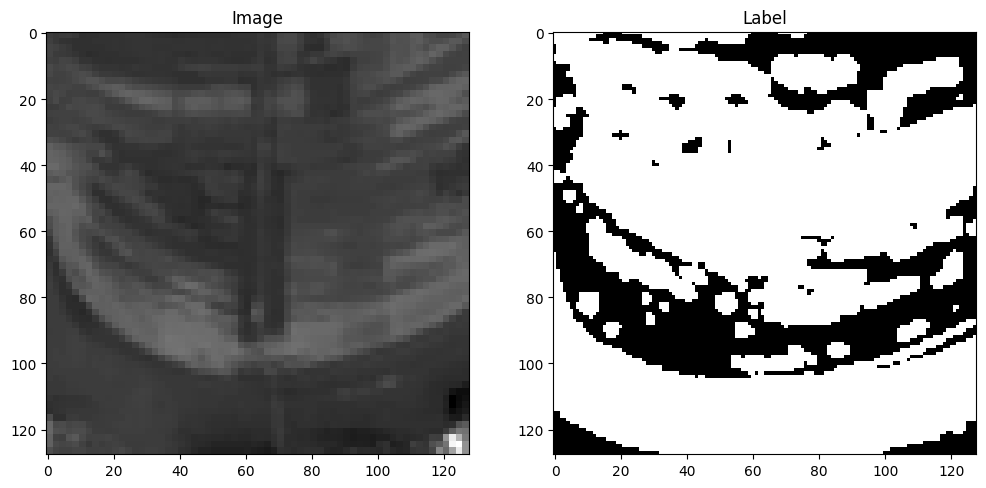

In [108]:
def visualize_sample(image, label):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image[..., 0], cmap='gray') 
    plt.subplot(1, 2, 2)
    plt.title('Label')
    plt.imshow(label[..., 0], cmap='gray')
    plt.show()

visualize_sample(images[0], labels[0])

In [109]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('unet_model.keras', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]


In [110]:
images_np = images.numpy()
labels_np = labels.numpy()

X_train, X_test, y_train, y_test = train_test_split(images_np, labels_np, test_size=0.2, random_state=42)

In [111]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def unet_model(input_size=(128, 128, 12)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.Conv2D(256, (2, 2), activation='relu', padding='same')(layers.UpSampling2D((2, 2))(conv4))
    concat5 = layers.concatenate([up5, conv3], axis=3)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = layers.Conv2D(128, (2, 2), activation='relu', padding='same')(layers.UpSampling2D((2, 2))(conv5))
    concat6 = layers.concatenate([up6, conv2], axis=3)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2D(64, (2, 2), activation='relu', padding='same')(layers.UpSampling2D((2, 2))(conv6))
    concat7 = layers.concatenate([up7, conv1], axis=3)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)


    model = Model(inputs=[inputs], outputs=[outputs])

    lr_schedule = ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9
    )
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

model = unet_model()

In [112]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_144 (Conv2D) │ (None, 128, 128,  │      6,976 │ input_layer_26[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_145 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_144[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_145[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_146 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_147 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_146[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_147[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_148 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_149 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_148[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_149[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_150 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_5[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_151 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_150[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_39    │ (None, 32, 32,    │          0 │ conv2d_151[0][0]  │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_152 (Conv2D) │ (None, 32, 32,    │    524,544 │ up_sampling2d_39… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_31      │ (None, 32, 32,    │          0 │ conv2d_152[0][0], │
│ (Concatenate)       │ 512)              │            │ conv2d_149[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_153 (Conv2D) │ (None, 32, 32,    │  1,179,904 │ concatenate_31[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_154 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_153[0][0]

 Total params: 7,702,529 (29.38 MB)

 Trainable params: 7,702,529 (29.38 MB)

 Non-trainable params: 0 (0.00 B)

In [113]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train,
                    y_train, 
                    epochs=30, 
                    batch_size=16, 
                    validation_split=0.1,                 
                    callbacks=callbacks)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 507ms/step - accuracy: 0.6524 - loss: 0.6758 - val_accuracy: 0.7636 - val_loss: 0.9572
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.7501 - loss: 0.6062 - val_accuracy: 0.7638 - val_loss: 0.5408
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.8624 - loss: 0.3775 - val_accuracy: 0.9058 - val_loss: 0.3046
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.9013 - loss: 0.2810 - val_accuracy: 0.9143 - val_loss: 0.3193
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.8951 - loss: 0.2933 - val_accuracy: 0.9146 - val_loss: 0.3380
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.9086 - loss: 0.2537 - val_accuracy: 0.9128 - val_loss: 0.3104
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.9098 - loss: 0.2539 - val_accuracy: 0.9153 - val_loss: 0.3320
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.9035 - loss: 0.2545 - val_accuracy: 0

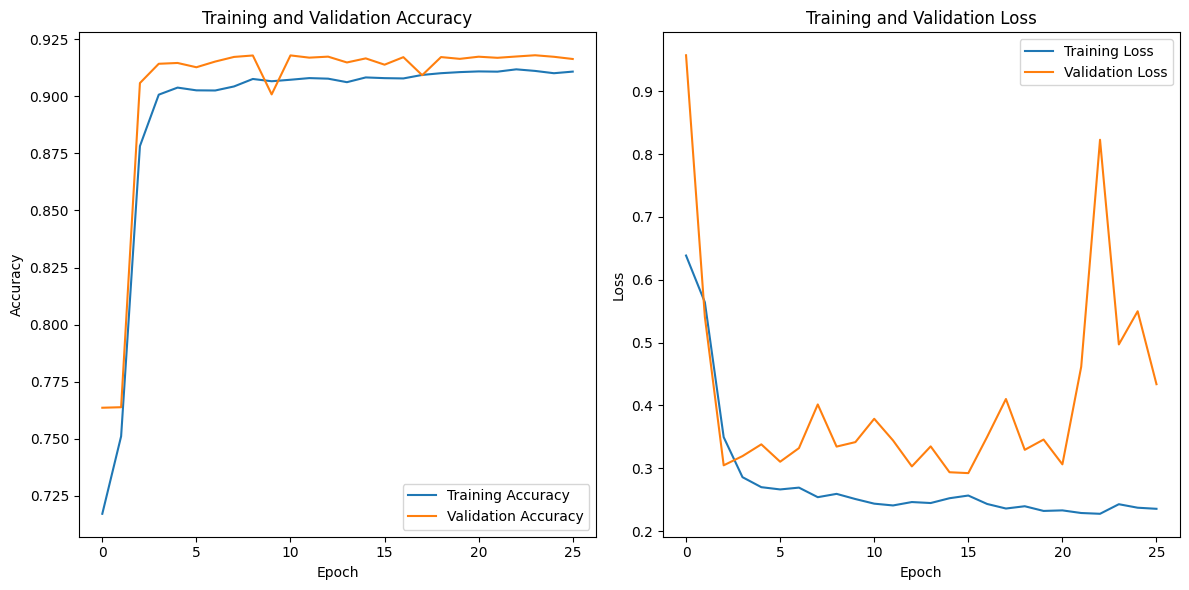

In [114]:
history_dict = history.history

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


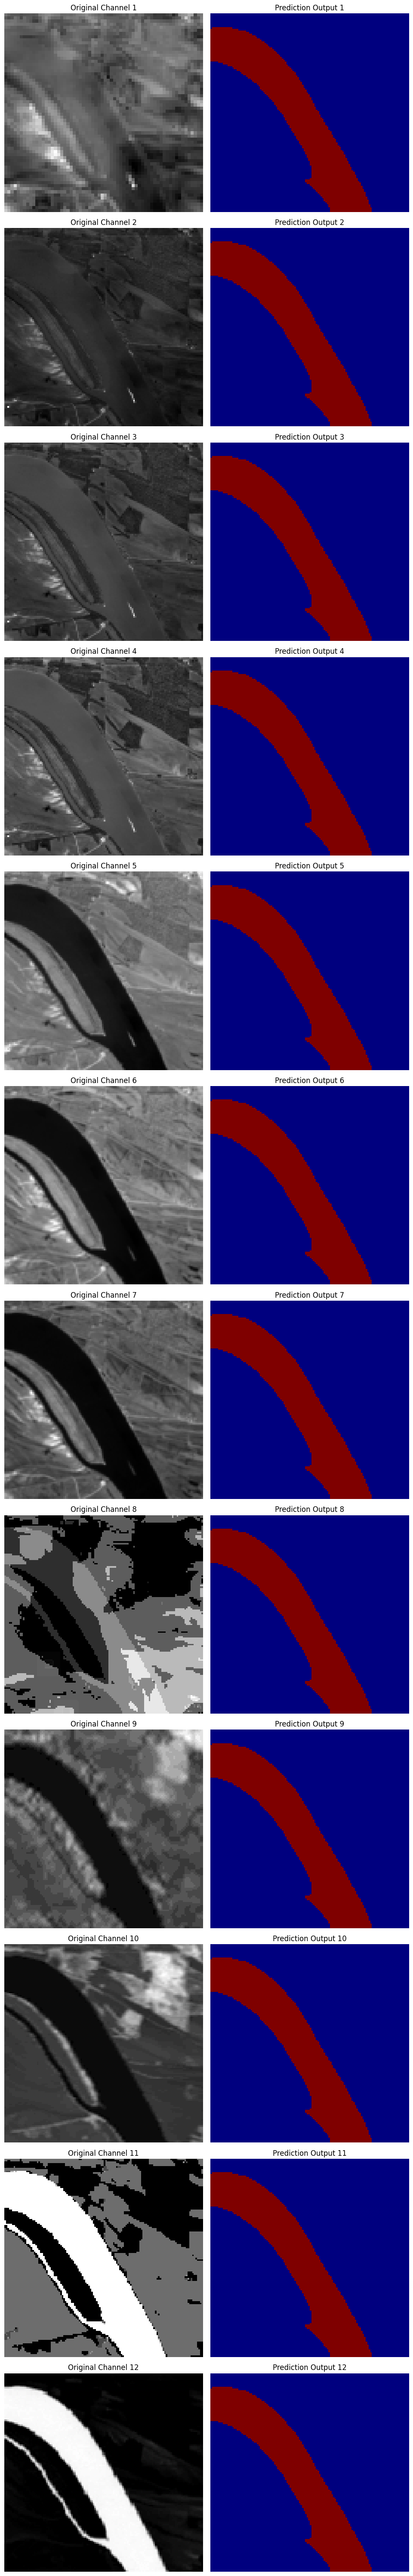

In [115]:
import tifffile as tiff
import matplotlib.pyplot as plt

image_path = '/kaggle/input/water-segmentation-dataset/data/images/277.tif'
image_array = tiff.imread(image_path).squeeze()

prediction_result = model.predict(image_array.reshape(1, 128, 128, 12)).squeeze()

num_channels = image_array.shape[2]
fig, axes = plt.subplots(num_channels, 2, figsize=(10, 5 * num_channels))

for i in range(num_channels):
    axes[i, 0].imshow(image_array[:, :, i], cmap='gray')
    axes[i, 0].set_title(f'Original Channel {i + 1}')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(prediction_result, cmap='jet')
    axes[i, 1].set_title(f'Prediction Output {i + 1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

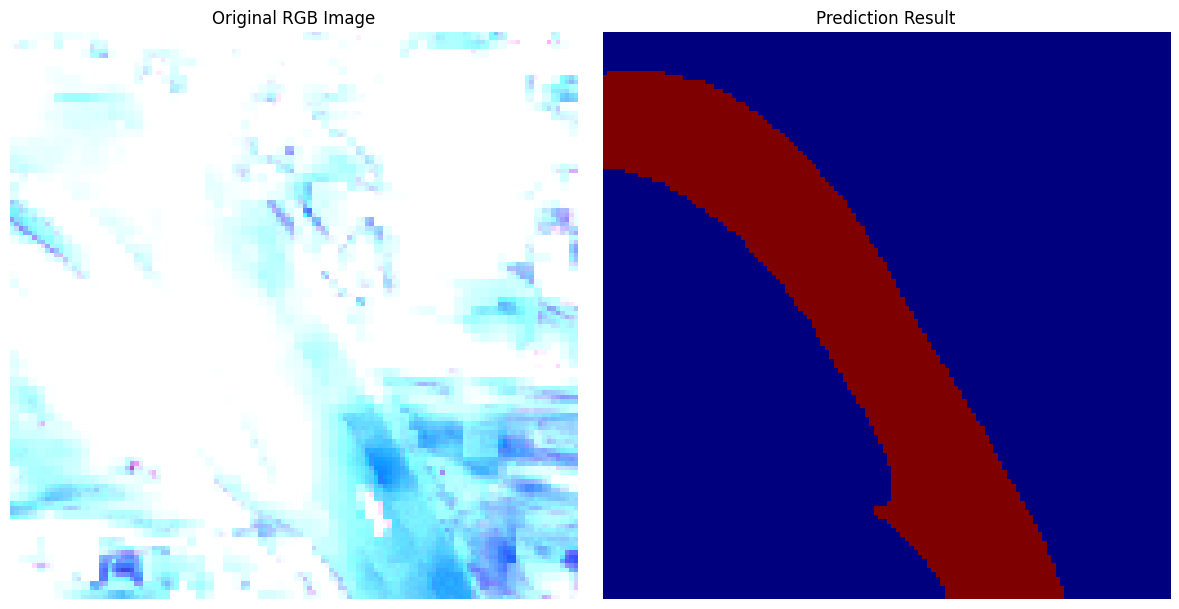

In [116]:
rgb_image = np.stack([image_array[:, :, 0], image_array[:, :, 1], image_array[:, :, 2]], axis=-1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(rgb_image)
axes[0].set_title('Original RGB Image')
axes[0].axis('off')

axes[1].imshow(prediction_result, cmap='jet')
axes[1].set_title('Prediction Result')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [117]:
model.save('my_model.keras')

In [118]:
if os.path.exists('my_model.keras'):
    print("File exists")
else:
    print("File does not exist")

File exists


In [119]:
from tensorflow.keras.models import load_model

res50_model = load_model('my_model.keras')

In [138]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

def unet_with_resnet50(input_size=(128, 128, 12)):
    inputs = layers.Input(input_size)
    
    # Adjust input channels for ResNet50 (ResNet50 expects 3 channels, but we use 12 input channels)
    x = layers.Conv2D(3, (1, 1), padding='same')(inputs)
    
    # First convolution layer similar to ResNet50 architecture
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(axis=-1, name='custom_conv1_bn')(x)
    x = layers.Activation('relu', name='custom_conv1_relu')(x)
    
    # Load ResNet50 without the top layers and with custom input tensor
    resnet50 = ResNet50(include_top=False, weights=None, input_tensor=x)
    
    # Extract the required layers from ResNet50
    conv1 = resnet50.get_layer('conv1_relu').output
    conv2 = resnet50.get_layer('conv2_block3_out').output
    conv3 = resnet50.get_layer('conv3_block4_out').output
    conv4 = resnet50.get_layer('conv4_block6_out').output
    
    # Decoder path (Upsampling and concatenation with skip connections)
    up5 = layers.Conv2D(256, (2, 2), activation='relu', padding='same')(layers.UpSampling2D((2, 2))(conv4))
    concat5 = layers.concatenate([up5, conv3], axis=3)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    
    up6 = layers.Conv2D(128, (2, 2), activation='relu', padding='same')(layers.UpSampling2D((2, 2))(conv5))
    concat6 = layers.concatenate([up6, conv2], axis=3)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = layers.Conv2D(64, (2, 2), activation='relu', padding='same')(layers.UpSampling2D((2, 2))(conv6))
    concat7 = layers.concatenate([up7, conv1], axis=3)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)
    
    # Upsample to match the input size (128x128)
    up8 = layers.UpSampling2D((4, 4))(conv7)  # Upsampling to match the original image size

    # Final output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(up8)
    
    # Define the model
    model = Model(inputs=[inputs], outputs=[outputs])
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
model = unet_with_resnet50()
model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_198 (Conv2D) │ (None, 128, 128,  │         39 │ input_layer_30[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_199 (Conv2D) │ (None, 64, 64,    │      9,472 │ conv2d_198[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_conv1_bn     │ (None, 64, 64,    │        256 │ conv2d_199[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_conv1_relu   │ (None, 64, 64,    │          0 │ custom_conv1_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70,    │          0 │ custom_conv1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │    200,768 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b

 Total params: 13,063,784 (49.83 MB)

 Trainable params: 13,033,064 (49.72 MB)

 Non-trainable params: 30,720 (120.00 KB)

In [139]:
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=60,  
                    batch_size=16, 
                    verbose=1
                   )

Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6715 - loss: 1.1284 - val_accuracy: 0.7629 - val_loss: 0.6469
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8083 - loss: 0.4548 - val_accuracy: 0.7616 - val_loss: 0.5995
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8709 - loss: 0.3534 - val_accuracy: 0.7551 - val_loss: 0.5586
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8897 - loss: 0.3054 - val_accuracy: 0.7755 - val_loss: 0.5382
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8827 - loss: 0.2983 - val_accuracy: 0.7543 - val_loss: 0.5315
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8998 - loss: 0.2864 - val_accuracy: 0.7580 - val_loss: 0.5043
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8987 - loss: 0.2637 - val_accuracy: 0.7559 - val_loss: 0.4976
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8939 - loss: 0.2689 - val_accuracy: 0.7578 - va

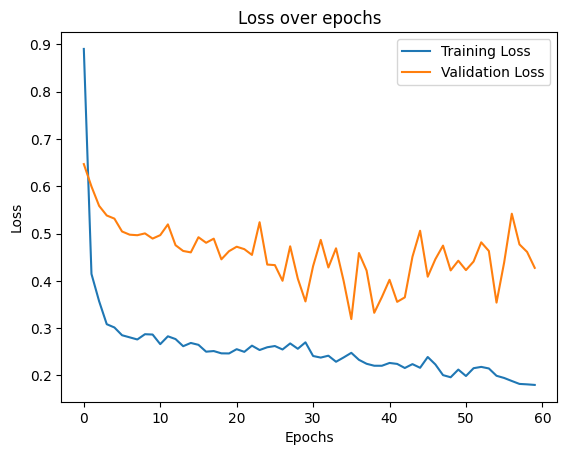

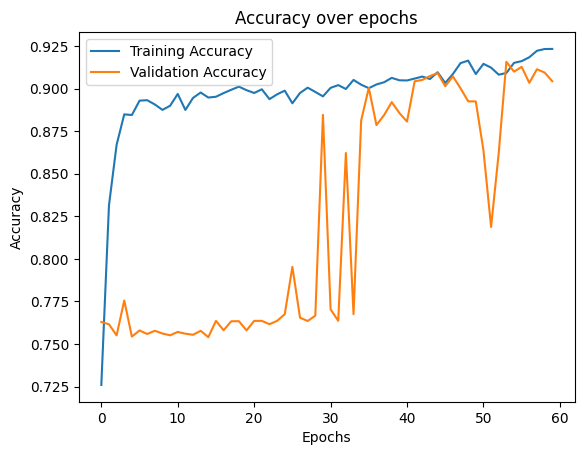

In [140]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [126]:
def combined_loss(y_true, y_pred):
    bce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice_loss = 1 - (2 * tf.reduce_sum(y_true * y_pred) + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)
    return bce_loss + dice_loss


In [127]:
model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy'])


In [128]:
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=60,  
                    batch_size=16, 
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5700 - loss: 32.1189 - val_accuracy: 0.7314 - val_loss: 46.9097
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8595 - loss: 0.7141 - val_accuracy: 0.6158 - val_loss: 5.7953
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8832 - loss: 0.6364 - val_accuracy: 0.8650 - val_loss: 1.0999
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.8654 - loss: 0.7166 - val_accuracy: 0.8899 - val_loss: 0.7008
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8772 - loss: 0.6659 - val_accuracy: 0.8950 - val_loss: 0.7972
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.8950 - loss: 0.6542 - val_accuracy: 0.9018 - val_loss: 0.6584
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8803 - loss: 0.6555 - val_accuracy: 0.9022 - val_loss: 0.6912
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8914 - loss: 0.5590 - val_accuracy: 0.9047 